# Questions/Concerns
=======================================

* Was/how was the main parachute bag held down for LV2?
* How many lines were cut during LV2 recovery?
    * What if the drogue gets cut away but the main does not deploy..then what?
* Need property to do flight testing over
    * Possible resources: Glenn, Asa, Jorden
* 

# Next steps (as of 8/23)

* Finalize surgical tubing ring
* Design attachment ring
* Email "The Rocketman" to see when parachutes will arrive
* Get in contact with Tim to talk about LV2

# LV2 Recovery System 
=======================================

## Given information

#### Drogue parachute

*Hand measured*

* Diameter (length of cross) = 54"

* Width = 17"

* Longest line length = 56"

#### Main parachute

*Reference Main.dxf*

* X-form shape

* Dimensions, total outer: 216.54" x 218.54"

* Dimensions, inner cross: 64.01"

* Corner line length, skirt to confluence: 205"

* Center lines lengthen 3%

*Hand measured*

* Diameter = 212"

* Width = 55"

* Longest line length = 198"

#### Assumptions$^{[1]}$:

    1. Linear motion
    2. The deployment system is inelastic
    3. The partially unfurled parachute is in tension during deployment
    4. The deployment rate is much less than the vehicle velocity
    
* The parachute depends on two main factors$^{[2]}$:

    1. The weight of the payload and parachute
    2. The speed upon impact when returning


In [6]:
# General
########################################

# Gravity (m/sec^2)
g = 9.81

# Air density (kg/m^3)
p = 1.225

In [7]:
# LV2 given information
#######################################

print ("LV2 Given Information\n")

# Mass of parachute (kg)
# From OpenRocket LV2.3.ork
m_p2 = 2.118

# Mass of system (rocket + chute) (kg)
# From OpenRocket LV2.3.ork
m_tot2 = 34.982

# Weight of system (N)
w_tot2 = m_tot2 * g
print ("weight")
print ("w_tot2 (N) %3.2f \n" % w_tot2)

# Main parachute dimensions, x-shape
# Diameter, d2 = length of one cross strip (m)
# Width of cross strip, w2 (m)
# Almost the same w/d ratio as AIAA source [4] (0.263 compared to 0.260)
# Line length, l2 (m)
d2 = 5.38
w2 = 1.40
l2 = 5.03

# Area of parachute from LV2 system
A2 = ((d2*w2)*2)-(w2**2)
print ("diameter")
print ("d2 (m) %3.2f" %d2)
print ("area")
print ("A2 (m^2) %3.2f" % A2)

LV2 Given Information

weight
w_tot2 (N) 343.17 

diameter
d2 (m) 5.38
area
A2 (m^2) 13.10


## LV2 recovery system analysis

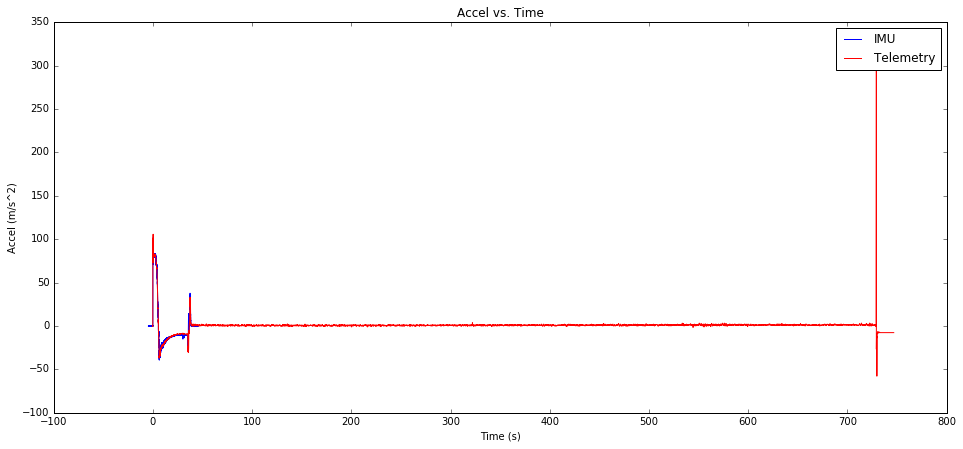

In [8]:
# Analyzing LV2 Telemetry and IMU data
# From git, Launch 12
#######################################

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import simps
%matplotlib inline

# Graphing helper function
def setup_graph(title='',x_label='', y_label='', fig_size=None):
    fig = plt.figure()
    if fig_size != None:
        fig.set_size_inches(fig_size[0],
                            fig_size[1])
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

########################################

# Data from the IMU
data = pd.read_csv('IMU_data.csv')

time = data[' [1]Timestamp'].tolist()
time = np.array(time)

# Umblicial disconnect event
t_0 = 117853569585227

# Element wise subtraction
time = np.subtract(time, t_0)

# Convert from ns to s
time = np.divide(time, 1e9)

acceleration = data[' [6]Acc_X'].tolist()
acceleration = np.array(acceleration)
acceleration = np.subtract(acceleration,g)

########################################

# Data from the Telemetrum
data_tel = pd.read_csv('Telemetry_data.csv')

time_tel = data_tel['time'].tolist()
time_tel = np.array(time_tel)

acceleration_tel = data_tel['acceleration'].tolist()
acceleration_tel = np.array(acceleration_tel)

setup_graph('Accel vs. Time', 'Time (s)', 'Accel (m/s^2)', (16,7))
plt.plot(time,acceleration,'b-')
plt.plot(time_tel, acceleration_tel,'r-')
plt.legend(['IMU','Telemetry'])
plt.show()

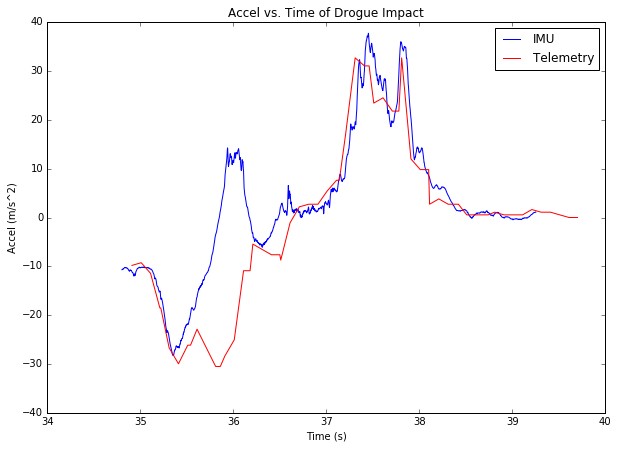

In [9]:
# Drogue analysis
# Plot of only the duration of impulse

setup_graph('Accel vs. Time of Drogue Impact', 'Time (s)', 'Accel (m/s^2)', (10,7))
plt.plot(time[len(time)-8700:35500], acceleration[len(acceleration)-8700:35500],'b-')
plt.plot(time_tel[len(time_tel)-9808:3377], acceleration_tel[len(acceleration_tel)-9808:3377],'r-')
plt.legend(['IMU','Telemetry'])
plt.show()

## suggestions

Your $dt$ value is a bit off. Also, $dt$ changes, especially when the drogue is deploying.

The other thing that I'd be careful about is your assumption that the deployment force is just the $\Delta v$ for deployment divided by the time. That would mean the force is as spread out as possible, which isn't true. 

Also, I think it's a reasonable guess that the IMU was zeroed on the launch pad. This means that 
1. The acceleration data isn't *quite* representative of the load on the parachute/rocket.
1. We can get a calibration factor for the IMU data.

At apogee, right before the drogue deploys, the rocket is basically in freefall. Aka, any accelerometer "should" read $0$. So, whatever the IMU reads at apogee is equal to $1 g$. We can then subtract out that value and scale the data so that we get $9.81$ on the launch pad. 

In [10]:
# how to get the values for dt:
#diffs= [t2-t1 for t1,t2 in zip(time[:-1], time[1:])]
#plt.figure()
#plt.plot(time[1:], diffs)
#plt.title('values of dt')
print('mean dt value:', np.mean(diffs))

# marginally nicer way to keep track of time windows:
ind_drogue= [i for i in range(len(time)) if ((time[i]>34.5) & (time[i]<39))]

# indices where we're basically in freefall:
ind_vomit= [i for i in range(len(time)) if ((time[i]>32) & (time[i]<34.5))]
offset_g= np.mean(acceleration[ind_vomit])
accel_nice = (acceleration-offset_g)*(-9.81/offset_g)
deltaV= sum([accel_nice[i]*diffs[i] for i in ind_drogue])
print('change in velocity (area under the curve):', deltaV)

plt.figure()
plt.plot(time[:2500], acceleration[:2500])
plt.title('launch pad acceleration')
print('"pretty much zeroed" value on the launch pad:', np.mean(acceleration[:2500]))

NameError: name 'diffs' is not defined

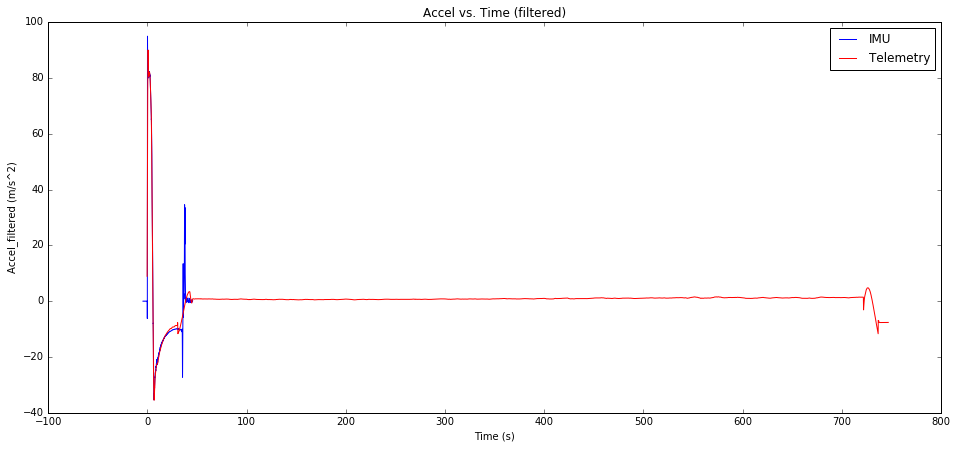

Estimating max possible impulse during LV2 

Area under entire filtered curve (m/s) 849.32
Area under accel curve during drogue impact (m/s) 45.80
Impulse (N*s) 1602.11
Force (N) 457.74


In [11]:
# Filtering out noise from IMU and Telemetry data w/ scipy
# Using these graphs to estimate max possible impulse felt during LV2

# From IMU
from scipy.signal import savgol_filter
accel_filtered = savgol_filter(acceleration, 201, 2)

# From telemetry
# ***Assuming the filter parameters will work for the telemetry data too***
accel_filtered_tel = savgol_filter(acceleration_tel, 201, 2)

# Plot of filtered IMU and telemetry for comparison
setup_graph('Accel vs. Time (filtered)', 'Time (s)', 'Accel_filtered (m/s^2)', (16,7))
plt.plot(time[1:], accel_filtered[1:],'b-')
plt.plot(time_tel[1:], accel_filtered_tel[1:],'r-')
plt.legend(['IMU','Telemetry'])
plt.show()
# Looks pretty darn close
# Wanted the filtered telemetry instead of IMU because IMU does not include landing and we need terminal velocity

print ("Estimating max possible impulse during LV2 \n")

# Estimate Area Under Curve
areaCurve = simps(abs(accel_filtered), dx=0.00125)
print ("Area under entire filtered curve (m/s) %3.2f" %areaCurve)

# Calculating area under drogue acceleration curve to find impulse
areaCurvesmall = simps(abs(accel_filtered[len(accel_filtered)-8700:35500]), dx=0.00125)
print ("Area under accel curve during drogue impact (m/s) %3.2f" %areaCurvesmall)

# Impulse = mass * integral(accel dt)
impulse = m_tot2 * areaCurvesmall
print ("Impulse (N*s) %3.2f" %impulse)

# If deploy time = approx. 3.5 sec
deploy_time = 3.5
force = impulse/deploy_time # not a conservative assumption
print ("Force (N) %3.2f" %force)

In [12]:
# Finding terminal velocity with height and time
# Assuming average velocity is equivalent to terminal velocity 
##because so much of the time after the main is deployed is at terminal velocity

# Using telemetry data
# Main 'chute deployment height (m)
main_deploy_height = 251.6
# Main 'chute deployment time (s)
main_deploy_time = 686.74
# Final height (m)
final_height = 0
# Final time
final_time = 728.51

# Average (terminal) velocity (m/s)
terminal_speed = abs((main_deploy_height - final_height)/(main_deploy_time - final_time))
print ("Terminal speed %3.2f" % terminal_speed)
# This seems accurate, 6 m/s is approx. 20 ft/s which is ideal

Terminal speed 6.02


In [13]:
# LV2 drag calculations
#######################################

# If we say at terminal velocity, accel = 0, 
# Therefore drag force (D2) = weight of system (w_tot2) (N)
# Because sum(forces) = ma = 0, then
D2 = w_tot2
print ("D2 (N) %3.2f" % D2)

# Calculated drag coefficient (Cd2), using D2
Cd2 = (2*D2)/(p*A2*(terminal_speed**2))
print ("Cd2 %3.2f" % Cd2)

# Drag coefficient (Cd_or), from OpenRocket LV2.3
# Compare to AIAA source [4], 0.60
# Compare to calculated from LV2 data, Cd2
Cd_or = 0.59
print ("Cd_or %3.2f" % Cd_or)

# Calculated drag (D_or) (N), from OpenRocket LV2.3
D_or = (Cd_or*p*A2*(terminal_speed**2))/2
print ("D_or (N) %3.2f" % D_or)

D2 (N) 343.17
Cd2 1.18
Cd_or 0.59
D_or (N) 171.81


# LV3 Recovery System
=======================================

## Overview

### Deployment design

<img src='Sketch_ Deployment_Design.jpg' width="450">

### Top-level design

<img src='Sketch_ Top-Level_Design.jpg' width="450">
<img src='initial_idea_given_info.jpg' width="450">

### Step-by-step

<img src='step_by_step.jpg' width="450">

## Deciding on a parachute

### Estimating necessary area

In [14]:
## **Need to decide on FOS for the weight and then use estimator to calculate necessary area** ##
# Calculating area needed for LV3 parachutes
# Both drogue and main

# From OpenRocket file LV3_L13a_ideal.ork
# Total mass (kg), really rough estimate
m_tot3 = 27.667
# Total weight (N)
w_tot3 = m_tot3 * g
print w_tot3
# Assuming drag is equivalent to weight of rocket system
D3 = w_tot3

# v_f3 (m/s), ideal terminal(impact) velocity
v_f3 = 6

# Cd from AIAA example (source 4)
Cd_aiaa = 0.60

# Cd from OpenRocket LV3
Cd_or3 = 0.38

# Printing previous parachute area for reference
print ("Previous parachute area %3.2f" %A2)

# Need to work on this...
"""
# Area needed using LV2 calculations (m^2)
A3_2 = (D3*2)/(Cd2*p*(v_f3**2))
print ("Area using Cd2 %3.2f" %A3_2)

# Area needed using LV2 OpenRocket (m^2)
A3_or2 = (D3*2)/(Cd_or*p*(v_f3**2))
print ("Area using Cd_or %3.2f" %A3_or2)

# Area needed using aiaa info (m^2)
A3_aiaa = (D3*2)/(Cd_aiaa*p*(v_f3**2))
print ("Area using Cd_aiaa %3.2f" %A3_aiaa)

# Area needed using LV3 OpenRocket
A3_or3 = (D3*2)/(Cd_or3*p*(v_f3**2))
print ("Area using Cd_or3 %3.2f" %A3_or3)

# Area estimater
A3 = (D3*2)/(1.5*p*(v_f3**2))
print ("Area estimate %3.2f" %A3)

import math
d_m = (math.sqrt(A3_or3/math.pi))*2
d_ft = d_m * 0.3048
print d_ft
"""

271.41327
Previous parachute area 13.10


'\n# Area needed using LV2 calculations (m^2)\nA3_2 = (D3*2)/(Cd2*p*(v_f3**2))\nprint ("Area using Cd2 %3.2f" %A3_2)\n\n# Area needed using LV2 OpenRocket (m^2)\nA3_or2 = (D3*2)/(Cd_or*p*(v_f3**2))\nprint ("Area using Cd_or %3.2f" %A3_or2)\n\n# Area needed using aiaa info (m^2)\nA3_aiaa = (D3*2)/(Cd_aiaa*p*(v_f3**2))\nprint ("Area using Cd_aiaa %3.2f" %A3_aiaa)\n\n# Area needed using LV3 OpenRocket\nA3_or3 = (D3*2)/(Cd_or3*p*(v_f3**2))\nprint ("Area using Cd_or3 %3.2f" %A3_or3)\n\n# Area estimater\nA3 = (D3*2)/(1.5*p*(v_f3**2))\nprint ("Area estimate %3.2f" %A3)\n\nimport math\nd_m = (math.sqrt(A3_or3/math.pi))*2\nd_ft = d_m * 0.3048\nprint d_ft\n'

### Sources for buying parachutes:

* [The Rocket Man](http://www.the-rocketman.com/chutes.html#standard)
    * Standard Low-Porosity 1.1 Ripstop
        * 16-18 ft based on provided chart (for 65 lbs)
        * $170.00 - $190.00
        
    * Pro-Experimental 1.9 Low-Porosity Ripstop
        * 14 ft
        * $225.00
        
    * Also sells drogue chutes

* [Fruity Chutes](https://fruitychutes.com/buyachute/contact_us.html)
    * Iris Ultra 120" Standard Parachute
        * 79 lbs @ 20 fps
        * $402.00
        
    * 120" Custom Parachute
        * 50 lbs @ 20 fps
        * Hemispherical
        * $355.00

* [Top Flight Recovery](http://topflightrecoveryllc.homestead.com/page1.html)
    * "Cutcom sizes of all of TFR parachutes available upon request"
    * Standard chute
        * PAR-120
        * 120"
        * 94.95
        * 16 shroud lines
    * Crossfire HD 6 Panel Chute (CF-120)
        * 120"
        * $169.95

        * says max load is 45 lbs?
        * 144", 65 lb max, $199.95

* [Rockets-r-us (Top Flight Recovery)](http://www.rocketsrus.com/top-flight-recovery.html)
    * Crossfire HD 6 Panel Chute (CF-120)
        * 120"
        * $152.96
        
    * Standard Chute
        * PAR-120
        * 120"
        * 16 shroud lines
        * $71.96

* [Performance Hobbies](http://performancehobbies.com/secure/store.aspx?groupid=39#_CrossfireHD6PanelChutes)
    * "Top Flight Recovery Products"
    * Crossfire HD 6 Panel Chute (CF-120)
        * 120"
        * $169.95

* [Proline Rocketry](http://prolinerocketry.com/store/index.php?cPath=6_12)
    * SkyAngle Cert 3 XXLarge
        * $239.00
        * 60.0 - 129.8 lbs
        * 129 sqft surface area
        * 120" line length
        
Ultimately, we decided to go with a main parachute, drogue parachute, and the corresponding bags from The Rocketman. We chose an 18' Standard main and a 5' drogue. The parachutes were bought on the bigger end of the spectrum because, as of Launch 13, this is the lightest that this version of the rocket be. It was convenient that we could buy everything from the same site, and the price was resonable compared to the other sites found. Reviews found on blogs were also favorable of The Rocketman.

### Volume of available space in nosecone

<img src='PSAS_nosecone_volume_conservative.jpg'>

## Attachment plate

### Initial attachment plate design

<img src='attachment_plate_design.jpg' width="450">

## Works Cited

[1] NASA TN D-5619

[2] http://www.pcprg.com/rocketre.htm

[3] http://www.dtic.mil/dtic/tr/fulltext/u2/731023.pdf

[4] AIAA-99-1711